## Image segmentation with CamVid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/images'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/valid.txt'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/labels')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/images/0016E5_08370.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/images/Seq05VD_f04110.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/images/0001TP_010170.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/labels/0016E5_01890_P.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/labels/Seq05VD_f00330_P.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/camvid/labels/Seq05VD_f01140_P.png')]

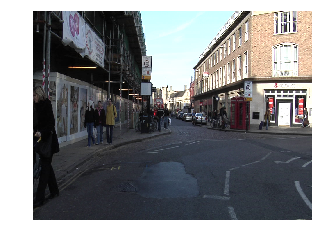

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

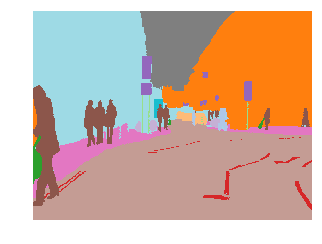

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[30, 30, 30,  ...,  4,  4,  4],
          [30, 30, 30,  ...,  4,  4,  4],
          [30, 30, 30,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [ ]:
size = src_size//2
bs=8

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

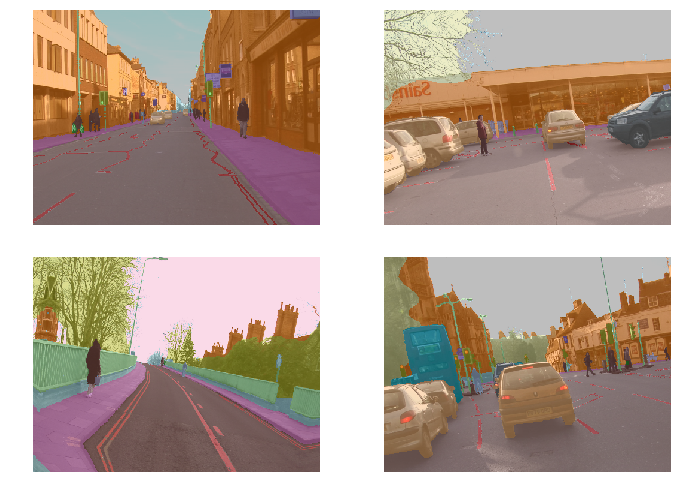

In [ ]:
data.show_batch(2, figsize=(10,7))

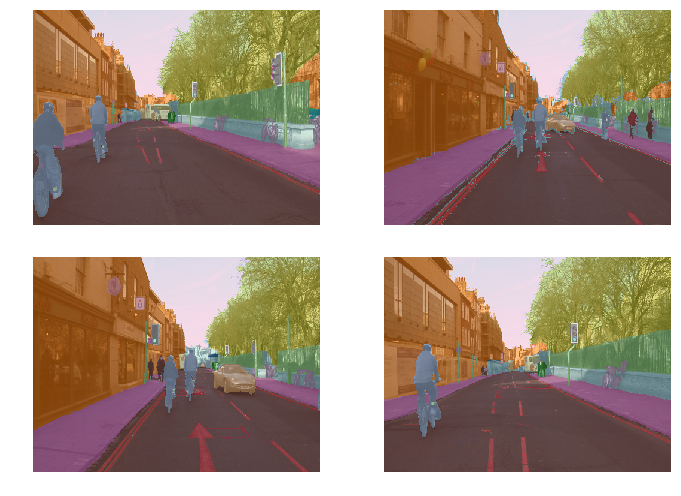

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


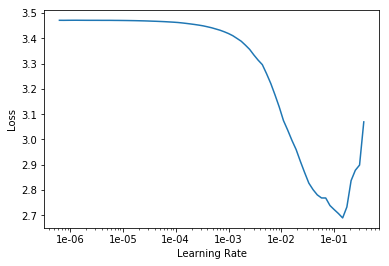

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-2

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 02:46
epoch  train_loss  valid_loss  acc_camvid
1      1.537235    0.785360    0.832015    (00:20)
2      0.905632    0.677888    0.842743    (00:15)
3      0.755041    0.759045    0.844444    (00:16)
4      0.673628    0.522713    0.854023    (00:16)
5      0.603915    0.495224    0.864088    (00:16)
6      0.557424    0.433317    0.879087    (00:16)
7      0.504053    0.419078    0.878530    (00:16)
8      0.457378    0.371296    0.889752    (00:16)
9      0.428532    0.347722    0.898966    (00:16)
10     0.409673    0.341935    0.901897    (00:16)



In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

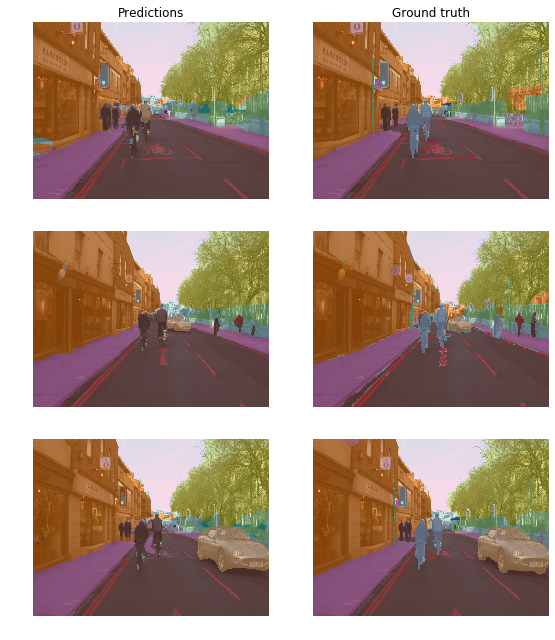

In [ ]:
learn.show_results()

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


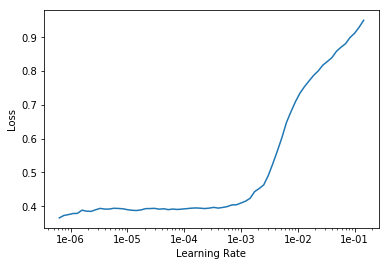

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/5)

In [ ]:
learn.fit_one_cycle(12, lrs)

Total time: 03:36
epoch  train_loss  valid_loss  acc_camvid
1      0.399582    0.338697    0.901930    (00:18)
2      0.406091    0.351272    0.897183    (00:18)
3      0.415589    0.357046    0.894615    (00:17)
4      0.407372    0.337691    0.904101    (00:18)
5      0.402764    0.340527    0.900326    (00:17)
6      0.381159    0.317680    0.910552    (00:18)
7      0.368179    0.312087    0.910121    (00:18)
8      0.358906    0.310293    0.911405    (00:18)
9      0.343944    0.299595    0.912654    (00:18)
10     0.332852    0.305770    0.911666    (00:18)
11     0.325537    0.294337    0.916766    (00:18)
12     0.320488    0.295004    0.916064    (00:18)



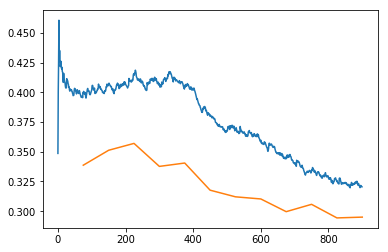

In [ ]:
learn.recorder.plot_losses()

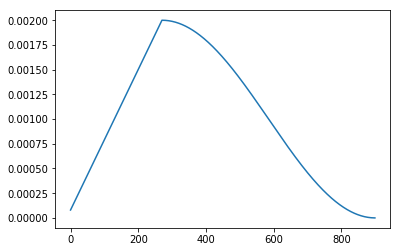

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=4

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


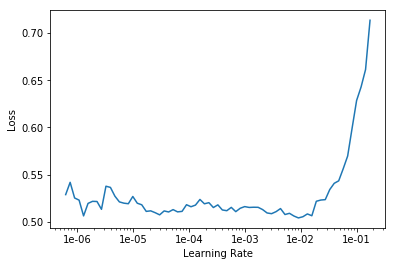

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:44
epoch  train_loss  valid_loss  acc_camvid
1      0.454597    0.349557    0.900428    (01:02)
2      0.418897    0.351502    0.897495    (00:51)
3      0.402104    0.330255    0.906775    (00:50)
4      0.385497    0.313330    0.911832    (00:51)
5      0.359252    0.297264    0.916108    (00:52)
6      0.335910    0.297875    0.917553    (00:50)
7      0.336133    0.305602    0.913439    (00:51)
8      0.321016    0.305374    0.914063    (00:51)
9      0.311554    0.299226    0.915997    (00:51)
10     0.308389    0.301060    0.915253    (00:51)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:30
epoch  train_loss  valid_loss  acc_camvid
1      0.323283    0.300749    0.915948    (00:56)
2      0.329482    0.290447    0.918337    (00:56)
3      0.324378    0.298494    0.920271    (00:57)
4      0.316414    0.296469    0.918053    (00:56)
5      0.305226    0.284694    0.920893    (00:57)
6      0.301774    0.306676    0.914202    (00:57)
7      0.279722    0.285487    0.919991    (00:57)
8      0.269306    0.285219    0.920963    (00:57)
9      0.260325    0.284758    0.922026    (00:57)
10     0.251017    0.285375    0.921562    (00:57)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

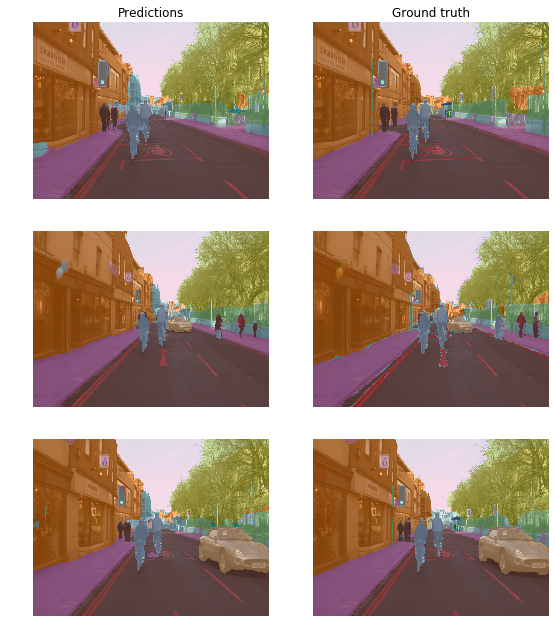

In [ ]:
learn.show_results()